Dices detection
=========================================
***Komunikacja człowiek-komputer 2021***   

**Authors**: Katarzyna Badio, Julia Chabora  

### Importing libraries

In [1]:
import numpy as np
import os
import cv2
from matplotlib import pylab as plt 
from ipywidgets import interact

### Preprocessing images

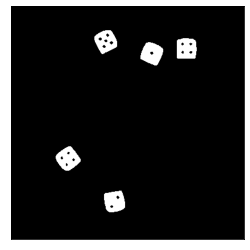

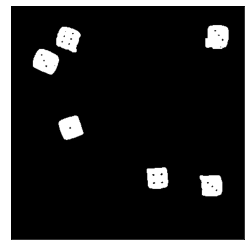

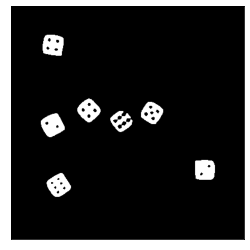

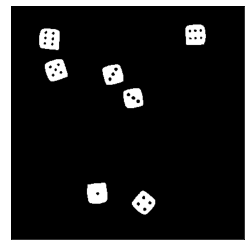

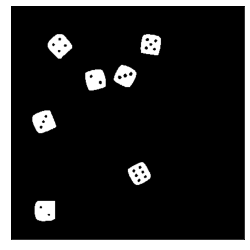

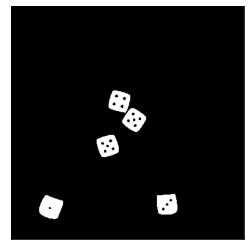

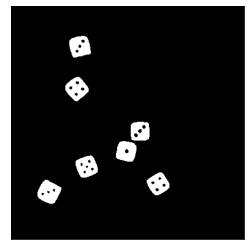

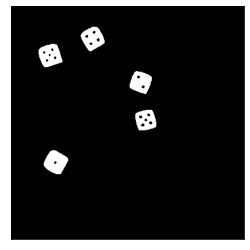

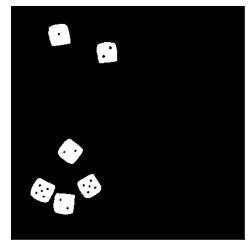

In [2]:
#directory = r'./images'
directory = r'./dices/selected-dataset-images'
#directory = r'./dices/board-game-dices'
#directory = r'./dices/selected-board-game-dices'

dices = []
original_dices = []
i = 0
for dice_image in os.scandir(directory):
    dices.append(dice_image.path)
    
    plt.figure(figsize=(30, 30))

    img = cv2.imread(dices[i])
    original_dices.append(img)
    
    # 0. Change colorscale to gray
    imggrayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 1. Blurring dices to remove sharp edges
    blur = cv2.blur(imggrayscale, (3, 3), 0)
    
    # 2. Threshold
    _, thresholded = cv2.threshold(blur, 120, 255, cv2.THRESH_BINARY)
    
    # 3. Erosion
    kernel = np.ones((1,1),np.uint8)
    erosion = cv2.erode(thresholded,kernel,iterations = 2)
    
    # 4. Dilation
    kernel1 = np.ones((3,3),np.uint8)
    dices[i] = cv2.dilate(erosion,kernel1,iterations = 1)
    
    
    ax = plt.subplot(6, 3, i+1)
    ax.imshow(dices[i], cmap='gray')
    ax.set_xticks([]), ax.set_yticks([])
    ax.axis([0, img.shape[1], img.shape[0], 0])
    
    i += 1 


## Results

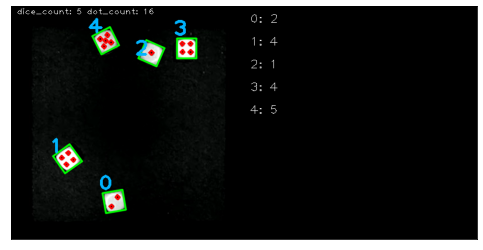

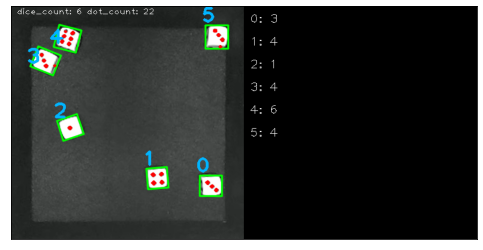

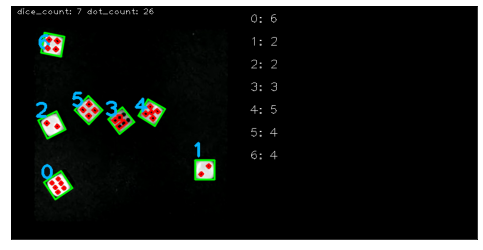

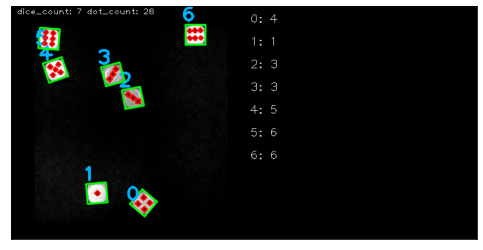

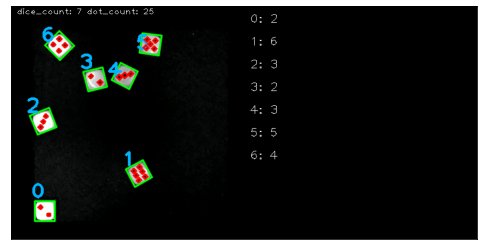

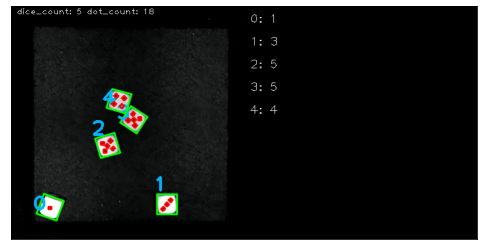

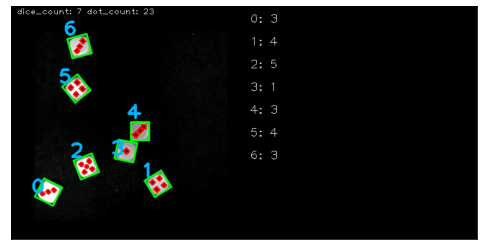

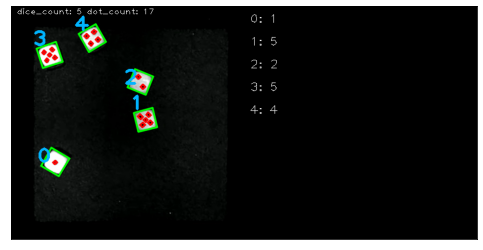

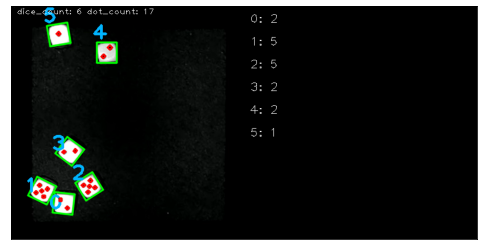

In [3]:
i = 0
dice_areas = []
for dice_image, original in zip(dices, original_dices):
    
    plt.figure(figsize=(30, 30))
   
    # 5. Finding contours of an image.
    contours, _ = cv2.findContours(dice_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # 6. Calculating areas of found contours.
    areas = []
    boxes_with_points = [] 
    for contour in contours:
        _, _, width, height = cv2.boundingRect(contour)
        areas.append(width*height)
        
    dice_areas.append(areas)

    # 6.1 Using average as a middle point to differ between dots and dices boxes
    labels = []
    dice_dict = {}
    dice_count = 0
    middle = (max(areas) - min(areas)) / 2
    for area in areas:
        if area > middle:
            labels.append('kostka')
            dice_dict[dice_count] = 0
            dice_count += 1
        else: 
            labels.append('oczko')


    dice_count = 0
    dot_count = 0
    for contour, label in zip(contours, labels):
        
         # 7. Drawing contours according to labels.
        rectangle = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rectangle)
        box = np.int0(box)
        
        if label == 'kostka':
            cv2.drawContours(original, [box], -1, (0, 255, 0), 2,  cv2.LINE_AA)
            # 7.1 Displaying id of dice in a picture
            cv2.putText(original, str(dice_count), (box[0][0] - 7, box[0][1] - 5), cv2.FONT_HERSHEY_PLAIN, 2.5, (0, 180, 255), 3)
            dice_count += 1
            
            
        elif label == 'oczko':
            cv2.drawContours(original, [box], -1, (255, 0, 0), 2,  cv2.LINE_AA)
            
            # 7.2 If dice for a dot is found -> ++
            M = cv2.moments(contour)
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            k = 0
            c = 0
            for label in labels:
                if label == 'kostka':
                    result = cv2.pointPolygonTest(contours[c], (cX, cY), False)
                    if result > 0:
                        dice_dict[k] += 1
                    k += 1
                c += 1
                    
            dot_count += 1
                        
    # 8. Put dice count and dot count text on a black image
    cv2.putText(original, "dice_count: "+ str(dice_count) + " dot_count: "+ str(dot_count), (10,15), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255))
    
    height, width, channels = original.shape
    # 9. Add blank black image and concatenate with original picture
    blank_image = np.zeros((height, width, channels), np.uint8)
    
    r = 30
    for key, value in dice_dict.items():
        cv2.putText(blank_image, str(key) + ": " + str(value), (10, r), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255))
        r += 40
        
    concatenated = cv2.hconcat([original, blank_image])

    ax = plt.subplot(6, 3, i+1)
    ax.imshow(concatenated)
    ax.set_xticks([]), ax.set_yticks([])
    ax.axis([0, concatenated.shape[1], concatenated.shape[0], 0])
    